In [145]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from functools import lru_cache

#! global settings
dtype   = torch.float64
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#! model information
L       = 6
PBC     = True

In [156]:
def loss_rayleigh(H: torch.Tensor, V: torch.Tensor, eigvals=None, gamma=0.0) -> torch.Tensor:
    """
    Calculate the Rayleight distance loss. 
    
    In a sense, what we do is we try to do is to create a representation of the Hamiltonian
    that will try to lead to eigenvectors that are the same as input. What is important,
    if the states are the eigenstates of the Hamiltonian, then the representation
    will be diagonal. Thus, we try to minimize the off-diagonal elements of the
    reduced Hamiltonian. 
    
    In addition, the diagonal elements can be forced to be close to the eigenvalues
    of the Hamiltonian. This is controlled by the parameter gamma. If gamma=0,
    then the diagonal elements are not forced to be close to the eigenvalues.
    
    Parameters
    ----------
    H : torch.Tensor
        The Hamiltonian matrix of shape (N, N).
    V : torch.Tensor
        The matrix of eigenvectors of shape (N, M).
    eigvals : torch.Tensor, optional
        The eigenvalues of the Hamiltonian of shape (M,), by default None.
    gamma : float, optional
        The weight of the eigenvalue loss term, by default 0.0.    
    """
    
    Hred    = V.T.conj() @ H @ V # (M, N) @ (M, M) @ (N, M) -> (M, M)
    off     = Hred - torch.diag(torch.diag(Hred))
    loss    = torch.linalg.norm(off, 'fro')**2 / V.shape[1]
    
    if eigvals is not None and gamma > 0:
        diag    = torch.diag(Hred)
        loss   += gamma * torch.linalg.norm(diag - eigvals, 2)**2 / V.shape[1]
    return loss

def loss_rayleigh_ritz_batch(H: torch.Tensor, V: torch.Tensor, eigvals: torch.Tensor | None = None, gamma: float = 0.0) -> torch.Tensor:
    """
    Batched version of the Rayleigh loss function.
    """
    B, D, M     = V.shape
    loss_total  = 0.0
    for b in range(B):
        loss_total += loss_rayleigh(H[b], V[b], eigvals[b] if eigvals is not None else None, gamma)
    return loss_total / B

### Hamiltonian $\hat{H}_{J_1, J_2}$ with different $J_1^i$ and $J_2^i$

$$

\hat{H}_{J_1, J_2} = \sum _{i=1}^{L}J_1^i h_{i,i+1} + \sum _{i=1}^{L}J_2^i h_{i,i+2}\;,

$$
$$

h_{ij} = \sigma ^x_i\sigma ^x_j + \sigma ^y_i\sigma ^y_j + \sigma ^z_i\sigma ^z_j \;.

$$

We prebuild the operators to make it efficiently calculated

In [149]:

# ------------------------------------------------------------------------------
# Kronecker product of two matrices
# ------------------------------------------------------------------------------

def kron_two(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return torch.kron(a, b)

# ------------------------------------------------------------------------------
#! PAULI
# ------------------------------------------------------------------------------

@lru_cache(maxsize=None)
def pauli_operators(dtype=torch.float64, device="cpu"):
    I = torch.tensor([[1., 0.],
                      [0., 1.]], dtype=dtype, device=device)
    Z = torch.tensor([[1.,  0.],
                      [0., -1.]], dtype=dtype, device=device)
    X = torch.tensor([[0., 1.],
                      [1., 0.]], dtype=dtype, device=device)
    Y = torch.tensor([[0., -1.],
                      [1.,  0.]], dtype=dtype, device=device) * 1j 
    return I, X, Y, Z

# ------------------------------------------------------------------------------
# Spin chain Heisenberg model with J1-J2 couplings
# ------------------------------------------------------------------------------

class SpinChainHeisenberg(nn.Module):
    def __init__(self, L: int, pbc: bool = True, dtype: torch.dtype = torch.float64, device: str = "cpu"):
        super().__init__()
        self.L          = L                 # Number of spins
        self.D          = 1 << L            # D = 2^L - Hilbert space dimension
        self.pbc        = pbc               # Periodic boundary conditions?
        self.device     = device            # Device to use
        self.dtype      = dtype             # Data type to use

        I, X, Y, Z      = pauli_operators(dtype=self.dtype, device=device)
        paulis          = (X, Y, Z)

        # Prebuild bond operator banks: list of (D x D) tensors for nearest and next-nearest
        self.register_buffer("H1", self._build_bank(paulis, nei=1))
        self.register_buffer("H2", self._build_bank(paulis, nei=2))

    # ----------------------------------------------------------------------------
    
    def _two_site(self, paulis, i, j):
        L, D, device, dtype = self.L, self.D, self.device, self.dtype
        
        #! Build two-site pauli interaction sum
        op = None
        for P in paulis:
            factors = []
            for s in range(self.L):
                if s == i:   factors.append(P)
                elif s == j: factors.append(P)
                else:        factors.append(torch.eye(2, dtype=dtype, device=device))
            
            #! Build Kronecker product
            term = factors[0]
            for f in factors[1:]:
                term = torch.kron(term, f)
            
            #! Sum up terms
            op = term if op is None else (op + term)
        # change dtype 
        return op.to(dtype)
    
    # ----------------------------------------------------------------------------

    def _build_bank(self, paulis, nei: int = 1):
        '''
        Build a bank of two-site operators for all bonds with given displacement.
        Parameters
        ----------
        paulis : tuple of torch.Tensor
            The Pauli operators (X, Y, Z).
        nei : int, optional
            The displacement between the two sites, by default 1 (nearest neighbours).
        Returns
        -------
        torch.Tensor
            A tensor of shape (n_bonds, D, D) containing the two-site operators
        '''
        idxs = []
        for i in range(self.L):
            j = ((i + nei) % self.L) if self.pbc else (i + nei)
            if j >= self.L:  # OBC case
                continue
            idxs.append((i, j))
        bank = [ self._two_site(paulis, i, j) for (i, j) in idxs ]
        return torch.stack(bank, dim=0) # shape: (n_bonds, D, D)

    # ----------------------------------------------------------------------------

    def forward(self, J1: torch.Tensor, J2: torch.Tensor) -> torch.Tensor:
        """
        Use the parameters J1, J2 to build the Hamiltonian.
        
        Parameters
        ----------
        J1, J2 : shape (L,) real
            The nearest and next-nearest neighbour couplings.
        Returns
        -------
        H : torch.Tensor
            The Hamiltonian matrix of shape (D, D).
        """
        # Match number of bonds in bank (OBC removes last bonds for disp>0)
        n1  = self.H1.shape[0]
        n2  = self.H2.shape[0]
        H   = torch.zeros((self.D, self.D), dtype=self.dtype, device=self.device)

        # Nearest neighbours
        for b in range(n1):
            i = b
            if J1[i] == 0:
                continue
            H = H + J1[i] * self.H1[b]
            
        # Next-nearest
        for b in range(n2):
            i = b
            if J2[i] == 0:
                continue
            H = H + J2[i] * self.H2[b]
        return H
    
    # ----------------------------------------------------------------------------

    def hamiltonian(self, theta: torch.Tensor) -> torch.Tensor:
        """
        Convert a parameter vector theta to the Hamiltonian matrix.
        
        Parameters
        ----------
        theta : torch.Tensor
            The parameter vector of shape (2L,) containing J1 and J2 couplings.
        
        Returns
        -------
        H : torch.Tensor
            The Hamiltonian matrix of shape (D, D).
        """
        L   = self.L
        J1  = theta[:L]
        J2  = theta[L:2*L]
        return self.forward(J1, J2)
    
    # ----------------------------------------------------------------------------

if False:
    Ltest               = 10
    test_hamiltonian    =  SpinChainHeisenberg(L=Ltest, pbc=True, dtype=dtype, device=device)
    theta               =  torch.randn(2 * test_hamiltonian.L, dtype=dtype, device=device)
    eigval, eigvec      = torch.linalg.eigh(test_hamiltonian.hamiltonian(theta))
    plt.plot(eigval.numpy(), 'o-')
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.title(f'Heisenberg J1-J2 model, L={Ltest}')

### Encoder and the network

In [152]:
class ProjectorEncoder(nn.Module):
    '''
    Convolutional encoder that maps input eigenvectors to Hamiltonian parameters.
    Input:
        (D, M) tensor of M eigenvectors of dimension D
    Output:
        (2L,) tensor of J1, J2 parameters for each bond
    '''
    def __init__(self, D: int, L: int, M: int, hidden: int = 256, dtype: torch.dtype = torch.float32, device: str = "cpu"):
        super().__init__()
        self.D          = D     # Hilbert space dimension
        self.M          = M     # Number of features - columns of eigenvectors
        self.L          = L     # Length of the spin chain
        self.out_dim    = 2 * L # J1, J2 for each bond
        self.dtype      = dtype
        self.device     = device

        self.conv1 = nn.Conv1d(in_channels=M, out_channels=32, kernel_size=1, dtype=self.dtype)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1, dtype=self.dtype)

        self.fc1   = nn.Linear(64 * D, hidden, dtype=self.dtype)
        self.fc2   = nn.Linear(hidden, hidden, dtype=self.dtype)
        self.fc_out= nn.Linear(hidden, self.out_dim, dtype=self.dtype)

    def forward(self, V: torch.Tensor):
        # V: (D, M)
        x       = V.transpose(0, 1)                     # (M, D)
        x       = x.unsqueeze(0)                        # (1, M, D)
        h       = F.gelu(self.conv1(x))                 # (1, 32, D)
        h       = F.gelu(self.conv2(h))                 # (1, 64, D)
        h       = h.view(-1)                            # flatten
        h       = F.gelu(self.fc1(h))
        h       = F.gelu(self.fc2(h))
        theta   = self.fc_out(h)
        return theta # parameters of the Hamiltonian
    
# ------------------------------------------------------------------------------

class EigSubspaceAutoencoder(nn.Module):
    '''
    Combines the encoder and the Hamiltonian builder to create
    an autoencoder that maps input eigenvectors to a Hamiltonian parameterization.
    '''
    def __init__(self,
                    L       : int, 
                    D       : int, 
                    dtype   : torch.dtype = torch.float32,
                    device  : str   = "cpu",
                    hidden  : int   = 256,
                    pbc     : bool  = True,
                    M       : int   = 6
                    ):
        super().__init__()
        self.L      = L
        self.D      = D
        self.device = device
        self.enc    = ProjectorEncoder(D=D, L=L, hidden=hidden, M=M, dtype=dtype, device=device)
        self.dec    = SpinChainHeisenberg(L=L, pbc=pbc, dtype=dtype, device=device)

    def split_theta(self, theta: torch.Tensor):
        # theta: (2L,) -> J1, J2 (L,)
        J1 = theta[:self.L]
        J2 = theta[self.L:]
        return J1, J2

    def forward(self, V: torch.Tensor):
        theta     = self.enc(V)                      # (2L,)
        J1, J2    = self.split_theta(theta)
        H         = self.dec(J1, J2)                 # (D, D)
        return H, (J1, J2), theta

# ------------------------------------------------------------------------------


### Training steps

In [153]:
def training_step(model         : EigSubspaceAutoencoder,
                optimizer       : torch.optim.Optimizer,
                V_batch         : torch.Tensor, # (B, D, M)
                eigvals_batch   : torch.Tensor | None = None,
                gamma           : float = 0.0):
    '''Training step for the autoencoder.'''
    
    # turn on training mode
    model.train()
    optimizer.zero_grad()

    # Forward pass: compute compute the loss for each item in the batch
    loss = 0.0
    for b in range(V_batch.shape[0]):
        Vb          = V_batch[b]
        H, _, _     = model(Vb)
        loss       += loss_rayleigh(H, Vb, eigvals=eigvals_batch[b] if eigvals_batch is not None else None, gamma=gamma)

    loss /= V_batch.shape[0]
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model: EigSubspaceAutoencoder, V_batch: torch.Tensor, eigvals_batch: torch.Tensor | None = None, gamma: float = 0.0):
    model.eval()
    with torch.no_grad():
        loss        = 0.0
        for b in range(V_batch.shape[0]):
            H, _, _ = model(V_batch[b])
            loss   += loss_rayleigh(H, V_batch[b], eigvals=eigvals_batch[b] if eigvals_batch is not None else None, gamma=gamma)
        loss /= V_batch.shape[0]
    return loss.item()

# ------------------------------------------------------------------------------

### Prepare the data

In [157]:
nsamples    = 100   # Total number of samples
ntrain      = 70    # Number of training samples
batch_size  = 16    # Size of the training batch
M           = 5     # Number of eigenvectors provided as input
j1s         = np.random.choice(np.arange(-2, 2, 1e-2), size=nsamples * L)
j2s         = np.random.choice(np.arange(-2, 2, 1e-2), size=nsamples * L)
js          = np.stack([j1s, j2s], axis=1).reshape(-1, 2 * L) # (nsamples, 2L)

model       = EigSubspaceAutoencoder(L=L, D=1<<L, dtype=dtype, device=device, hidden=512, M=M)
optimizer   = torch.optim.Adam(model.parameters(), lr=1e-4)

training_v  = []
training_e  = []
testing_v   = []
testing_e   = []
for n in range(nsamples):
    H               = model.dec.hamiltonian(torch.tensor(js[n], dtype=dtype, device=device))
    evals, evecs    = torch.linalg.eigh(H)
    if n < ntrain:
        training_v.append(evecs[:, :M].cpu())
        training_e.append(evals[:M].cpu())
    else:
        testing_v.append(evecs[:, :M].cpu())
        testing_e.append(evals[:M].cpu())

In [158]:
#! Training loop
n_epochs    = 500
gamma       = 0.1
train_V     = torch.stack(training_v, dim=0).to(device) # (ntrain, D, M)
train_E     = torch.stack(training_e, dim=0).to(device) # (ntrain, M)
test_V      = torch.stack(testing_v, dim=0).to(device)  # (ntest, D, M)
test_E      = torch.stack(testing_e, dim=0).to(device)  # (ntest, M)
print(f"Training on {train_V.shape[0]} samples, testing on {test_V.shape[0]} samples.")
print(f"Shapes are: V_train {train_V.shape}, E_train {train_E.shape}, V_test {test_V.shape}, E_test {test_E.shape}")
train_losses, test_losses = [], []

for epoch in range(n_epochs):
    # shuffle training set
    perm        = torch.randperm(ntrain)
    train_loss  = 0.0

    for i in range(0, ntrain, batch_size):
        idx         = perm[i:i+batch_size]
        V_batch     = train_V[idx]
        E_batch     = train_E[idx] if gamma > 0 else None
        loss        = training_step(model, optimizer, V_batch, eigvals_batch=E_batch, gamma=gamma)
        train_loss += loss * V_batch.shape[0]

    train_loss /= ntrain
    train_losses.append(train_loss)

    # test set evaluation
    test_loss = 0.0
    for i in range(0, test_V.shape[0], batch_size):
        V_batch     = test_V[i:i+batch_size]
        E_batch     = test_E[i:i+batch_size] if gamma > 0 else None
        loss        = evaluate(model, V_batch, eigvals_batch=E_batch, gamma=gamma)
        test_loss  += loss
    test_loss      /= test_V.shape[0]
    test_losses.append(test_loss)

    if epoch % 10 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch:4d}/{n_epochs}: Train Loss = {train_loss:.6e}, Test Loss = {test_loss:.6e}")

Training on 70 samples, testing on 30 samples.
Shapes are: V_train torch.Size([70, 64, 5]), E_train torch.Size([70, 5]), V_test torch.Size([30, 64, 5]), E_test torch.Size([30, 5])
Epoch    0/500: Train Loss = 1.525882e+01, Test Loss = 1.037108e+00
Epoch   10/500: Train Loss = 7.005077e+00, Test Loss = 6.055242e-01
Epoch   20/500: Train Loss = 6.855731e+00, Test Loss = 6.070492e-01
Epoch   30/500: Train Loss = 6.760030e+00, Test Loss = 6.304438e-01
Epoch   40/500: Train Loss = 6.687478e+00, Test Loss = 6.208725e-01
Epoch   50/500: Train Loss = 6.496851e+00, Test Loss = 6.192219e-01
Epoch   60/500: Train Loss = 6.223963e+00, Test Loss = 6.178005e-01
Epoch   70/500: Train Loss = 5.805358e+00, Test Loss = 6.067028e-01
Epoch   80/500: Train Loss = 4.990333e+00, Test Loss = 5.823358e-01
Epoch   90/500: Train Loss = 3.843990e+00, Test Loss = 6.263581e-01
Epoch  100/500: Train Loss = 2.781749e+00, Test Loss = 6.135944e-01
Epoch  110/500: Train Loss = 2.104782e+00, Test Loss = 6.330483e-01
Epoc

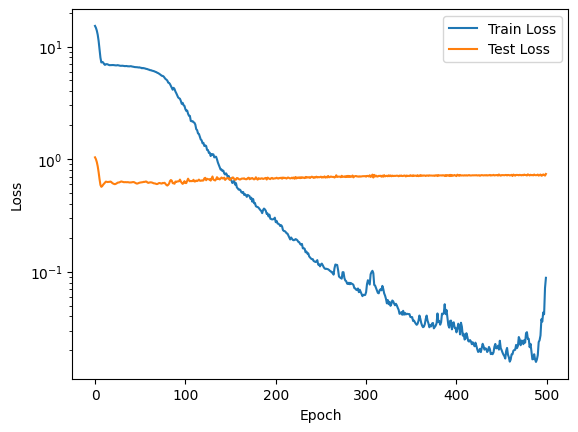

In [159]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()